In [17]:
%store -r clipped_downwind_wedge clipped_upwind_wedge clipped_urban_circle stats_downwind stats_upwind stats_circle
%store -r area_downwind_km2 area_upwind_km2 area_urban_km2 summed_precip

In [18]:
import pandas as pd
from shapely.geometry import Point
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set matplotlib parameters
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.facecolor'] = 'white'

In [19]:
'''
precip_2021 = pd.read_csv("C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/precip/Precip_2021.csv")
precip_2022 = pd.read_csv("C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/precip/Precip_2022.csv")

summed_precip_2021 = precip_2021.groupby(['Longitude', 'Latitude']).Precipitation.sum().reset_index()
summed_precip_2021['Longitude'] = summed_precip_2021['Longitude'] - 360

summed_precip_2022 = precip_2022.groupby(['Longitude', 'Latitude']).Precipitation.sum().reset_index()
summed_precip_2022['Longitude'] = summed_precip_2022['Longitude'] - 360

summed_precip = pd.concat([summed_precip_2021, summed_precip_2022], ignore_index=True)
%store summed_precip
'''


'\nprecip_2021 = pd.read_csv("C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/precip/Precip_2021.csv")\nprecip_2022 = pd.read_csv("C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/precip/Precip_2022.csv")\n\nsummed_precip_2021 = precip_2021.groupby([\'Longitude\', \'Latitude\']).Precipitation.sum().reset_index()\nsummed_precip_2021[\'Longitude\'] = summed_precip_2021[\'Longitude\'] - 360\n\nsummed_precip_2022 = precip_2022.groupby([\'Longitude\', \'Latitude\']).Precipitation.sum().reset_index()\nsummed_precip_2022[\'Longitude\'] = summed_precip_2022[\'Longitude\'] - 360\n\nsummed_precip = pd.concat([summed_precip_2021, summed_precip_2022], ignore_index=True)\n%store summed_precip\n'

## Obtain rain data in the regions

In [20]:
rain_lon = summed_precip['Longitude']
rain_lat = summed_precip['Latitude']

points = [Point(lon, lat) for lon, lat in zip(rain_lon, rain_lat)]
rain_points_downwind = [point for i, point in enumerate(points) if clipped_downwind_wedge.contains(point)]
rain_downwind = pd.DataFrame([(point.x, point.y) for point in rain_points_downwind], columns=['Longitude', 'Latitude'])
rain_in_downwind_wedge = pd.merge(summed_precip, rain_downwind, on=['Longitude', 'Latitude'])

points = [Point(lon, lat) for lon, lat in zip(rain_lon, rain_lat)]
rain_points_upwind = [point for i, point in enumerate(points) if clipped_upwind_wedge.contains(point)]
rain_upwind = pd.DataFrame([(point.x, point.y) for point in rain_points_upwind], columns=['Longitude', 'Latitude'])
rain_in_upwind_wedge = pd.merge(summed_precip, rain_upwind, on=['Longitude', 'Latitude'])

points = [Point(lon, lat) for lon, lat in zip(rain_lon, rain_lat)]
rain_points_urban = [point for i, point in enumerate(points) if clipped_urban_circle.contains(point)]
rain_urban = pd.DataFrame([(point.x, point.y) for point in rain_points_urban], columns=['Longitude', 'Latitude'])
rain_in_urban_circle = pd.merge(summed_precip, rain_urban, on=['Longitude', 'Latitude'])

%store rain_in_downwind_wedge rain_in_upwind_wedge rain_in_urban_circle

Stored 'rain_in_downwind_wedge' (DataFrame)
Stored 'rain_in_upwind_wedge' (DataFrame)
Stored 'rain_in_urban_circle' (DataFrame)


### Let's examine the stats for each region separately

In [21]:
stats_circle

<xarray.Dataset>
Dimensions:                  (tracks: 7446, times: 100)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 25311 25312 25323 25327
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) int32 7 3 18 15 2 9 6 ... 2 20 11 2 6 4 2
    base_time                (tracks, times) datetime64[ns] 2022-06-01T00:01:...
    meanlat                  (tracks, times) float32 28.89 28.9 ... nan nan
    meanlon                  (tracks, times) float32 -95.67 -95.68 ... nan nan
    area                     (tracks, times) float32 20.5 19.0 15.25 ... nan nan
    cloudnumber              (tracks, times) float64 1.0 4.0 6.0 ... nan nan nan
    ...                       ...
    start_split_tracknumber  (tracks) float64 nan nan nan ... 1.166e+04 nan nan
    start_split_timeindex    (tracks) float64 nan nan nan nan ... 13.0 nan nan
    start_split_cloudnumber  (tracks) float64 nan nan nan nan ... 1.0 nan nan
    end_merge_tracknumber    (tracks) float64 nan nan nan nan ... nan nan nan
    end_merge_timeindex      (tracks) float64 nan nan nan nan ... nan nan nan
    end_merge_cloudnumber    (tracks) float64 nan nan nan nan ... nan nan nan
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Mon Jul 10 21:16:26 2023
    startdate:             20220601.0000
    enddate:               20220630.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [22]:
tracks_circle = stats_circle['tracks']
times_circle = stats_circle['times']

time_res_circle = stats_circle.attrs['time_resolution_hour']
lifetime_circle = stats_circle['track_duration'] * time_res_circle

start_time_circle = stats_circle['start_basetime']
end_time_circle = stats_circle['end_basetime']
end_merge_tracknumber_circle = stats_circle['end_merge_tracknumber']
start_split_tracknumber_circle = stats_circle['start_split_tracknumber']
cell_lon_circle = stats_circle['cell_meanlon']
cell_lat_circle = stats_circle['cell_meanlat']
cell_area_circle = stats_circle['cell_area']
core_area_circle = stats_circle['core_area']
maxrange_flag_circle = stats_circle['maxrange_flag']

maxdbz_circle = stats_circle['max_dbz']
eth20_circle = stats_circle['maxETH_20dbz']


# Get track start values
ntracks_circle = stats_circle.dims['tracks']
start_maxrange_flag_circle = maxrange_flag_circle.isel(times=0)
start_lon_circle = cell_lon_circle.isel(times=0)
start_lat_circle = cell_lat_circle.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration_circle = (lifetime_circle.values / time_res_circle).astype(int)
rangeflag_circle = maxrange_flag_circle.values
celllon_circle = cell_lon_circle.values
celllat_circle = cell_lat_circle.values

end_maxrange_flag_circle = np.ones(ntracks_circle, dtype=float)
end_lon_circle = np.full(ntracks_circle, np.NaN, dtype=float)
end_lat_circle = np.full(ntracks_circle, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks_circle):
    # Get duration for the track
    iduration = duration_circle[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag_circle[ii,0:iduration]
    icell_lon = celllon_circle[ii,0:iduration]
    icell_lat = celllat_circle[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag_circle[ii] = imaxrangeflag[-1]
    end_lon_circle[ii] = icell_lon[-1]
    end_lat_circle[ii] = icell_lat[-1]


# Get track start/end hour
start_hour_circle = start_time_circle.dt.hour
end_hour_circle = end_time_circle.dt.hour

# Find tracks not end with merge or not start with split
nonmerge_circle = np.where(np.isnan(end_merge_tracknumber_circle))[0]
nonsplit_circle = np.where(np.isnan(start_split_tracknumber_circle))[0]
ntracks_nonmerge_circle = len(nonmerge_circle)
ntracks_nonsplit_circle = len(nonsplit_circle)
print(f'Number of non-merge tracks in urban region: {ntracks_nonmerge_circle}')
print(f'Number of non-split tracks in urban region: {ntracks_nonsplit_circle}')

nonsplit_in_circle = np.where(np.isnan(start_split_tracknumber_circle) & (start_maxrange_flag_circle == 1))[0]
nonmerge_in_circle = np.where(np.isnan(end_merge_tracknumber_circle) & (end_maxrange_flag_circle == 1))[0]
ntracks_nonsplit_in_circle = len(nonsplit_in_circle)
ntracks_nonmerge_in_circle = len(nonmerge_in_circle)
print(f'Number of non-split tracks within max range in urban region: {ntracks_nonsplit_in_circle}')
print(f'Number of non-merge tracks within max range in urban region: {ntracks_nonmerge_in_circle}')

merge_circle = np.where(end_merge_tracknumber_circle > 0)[0]
split_circle = np.where(start_split_tracknumber_circle > 0)[0]
ntracks_merge_circle = len(merge_circle)
ntracks_split_circle = len(split_circle)
print(f'Number of merge tracks in urban region: {ntracks_merge_circle}')
print(f'Number of split tracks in urban region: {ntracks_split_circle}')

Number of non-merge tracks in urban region: 6016
Number of non-split tracks in urban region: 5970
Number of non-split tracks within max range in urban region: 0
Number of non-merge tracks within max range in urban region: 0
Number of merge tracks in urban region: 1430
Number of split tracks in urban region: 1476


In [23]:
stats_upwind

<xarray.Dataset>
Dimensions:                  (tracks: 10906, times: 100)
Coordinates:
  * tracks                   (tracks) int64 0 3 4 7 ... 25267 25287 25316 25324
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) int32 7 15 2 2 2 3 5 4 ... 2 1 8 2 3 4 5 4
    base_time                (tracks, times) datetime64[ns] 2022-06-01T00:01:...
    meanlat                  (tracks, times) float32 28.89 28.9 ... nan nan
    meanlon                  (tracks, times) float32 -95.67 -95.68 ... nan nan
    area                     (tracks, times) float32 20.5 19.0 15.25 ... nan nan
    cloudnumber              (tracks, times) float64 1.0 4.0 6.0 ... nan nan nan
    ...                       ...
    start_split_tracknumber  (tracks) float64 nan nan nan nan ... nan nan nan
    start_split_timeindex    (tracks) float64 nan nan nan nan ... nan nan nan
    start_split_cloudnumber  (tracks) float64 nan nan nan nan ... nan nan nan
    end_merge_tracknumber    (tracks) float64 nan nan nan nan ... nan nan nan
    end_merge_timeindex      (tracks) float64 nan nan nan nan ... nan nan nan
    end_merge_cloudnumber    (tracks) float64 nan nan nan nan ... nan nan nan
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Mon Jul 10 21:16:26 2023
    startdate:             20220601.0000
    enddate:               20220630.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [24]:
tracks_upwind = stats_upwind['tracks']
times_upwind = stats_upwind['times']

time_res_upwind = stats_upwind.attrs['time_resolution_hour']
lifetime_upwind = stats_upwind['track_duration'] * time_res_upwind

start_time_upwind = stats_upwind['start_basetime']
end_time_upwind = stats_upwind['end_basetime']
end_merge_tracknumber_upwind = stats_upwind['end_merge_tracknumber']
start_split_tracknumber_upwind = stats_upwind['start_split_tracknumber']
cell_lon_upwind = stats_upwind['cell_meanlon']
cell_lat_upwind = stats_upwind['cell_meanlat']
cell_area_upwind = stats_upwind['cell_area']
core_area_upwind = stats_upwind['core_area']
maxrange_flag_upwind = stats_upwind['maxrange_flag']

maxdbz_upwind = stats_upwind['max_dbz']
eth20_upwind = stats_upwind['maxETH_20dbz']


# Get track start values
ntracks_upwind = stats_upwind.dims['tracks']
start_maxrange_flag_upwind = maxrange_flag_upwind.isel(times=0)
start_lon_upwind = cell_lon_upwind.isel(times=0)
start_lat_upwind = cell_lat_upwind.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration_upwind = (lifetime_upwind.values / time_res_upwind).astype(int)
rangeflag_upwind = maxrange_flag_upwind.values
celllon_upwind = cell_lon_upwind.values
celllat_upwind = cell_lat_upwind.values

end_maxrange_flag_upwind = np.ones(ntracks_upwind, dtype=float)
end_lon_upwind = np.full(ntracks_upwind, np.NaN, dtype=float)
end_lat_upwind = np.full(ntracks_upwind, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks_upwind):
    # Get duration for the track
    iduration = duration_upwind[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag_upwind[ii,0:iduration]
    icell_lon = celllon_upwind[ii,0:iduration]
    icell_lat = celllat_upwind[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag_upwind[ii] = imaxrangeflag[-1]
    end_lon_upwind[ii] = icell_lon[-1]
    end_lat_upwind[ii] = icell_lat[-1]


# Get track start/end hour
start_hour_upwind = start_time_upwind.dt.hour
end_hour_upwind = end_time_upwind.dt.hour

# Find tracks not end with merge or not start with split
nonmerge_upwind = np.where(np.isnan(end_merge_tracknumber_upwind))[0]
nonsplit_upwind = np.where(np.isnan(start_split_tracknumber_upwind))[0]
ntracks_nonmerge_upwind = len(nonmerge_upwind)
ntracks_nonsplit_upwind = len(nonsplit_upwind)
print(f'Number of non-merge tracks in upwind region: {ntracks_nonmerge_upwind}')
print(f'Number of non-split tracks in upwind region: {ntracks_nonsplit_upwind}')

nonsplit_in_upwind = np.where(np.isnan(start_split_tracknumber_upwind) & (start_maxrange_flag_upwind == 1))[0]
nonmerge_in_upwind = np.where(np.isnan(end_merge_tracknumber_upwind) & (end_maxrange_flag_upwind == 1))[0]
ntracks_nonsplit_in_upwind = len(nonsplit_in_upwind)
ntracks_nonmerge_in_upwind = len(nonmerge_in_upwind)
print(f'Number of non-split tracks within max range in upwind region: {ntracks_nonsplit_in_upwind}')
print(f'Number of non-merge tracks within max range in upwind region: {ntracks_nonmerge_in_upwind}')

merge_upwind = np.where(end_merge_tracknumber_upwind > 0)[0]
split_upwind = np.where(start_split_tracknumber_upwind > 0)[0]
ntracks_merge_upwind = len(merge_upwind)
ntracks_split_upwind = len(split_upwind)
print(f'Number of merge tracks in upwind region: {ntracks_merge_upwind}')
print(f'Number of split tracks in upwind region: {ntracks_split_upwind}')

Number of non-merge tracks in upwind region: 9066
Number of non-split tracks in upwind region: 9141
Number of non-split tracks within max range in upwind region: 0
Number of non-merge tracks within max range in upwind region: 0
Number of merge tracks in upwind region: 1840
Number of split tracks in upwind region: 1765


In [25]:
stats_downwind

<xarray.Dataset>
Dimensions:                  (tracks: 4020, times: 100)
Coordinates:
  * tracks                   (tracks) int64 14 32 43 57 ... 25331 25332 25333
  * times                    (times) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Data variables: (12/37)
    track_duration           (tracks) int32 2 3 2 2 15 4 2 5 ... 3 1 1 4 2 4 1 3
    base_time                (tracks, times) datetime64[ns] 2022-06-01T00:20:...
    meanlat                  (tracks, times) float32 30.02 30.02 nan ... nan nan
    meanlon                  (tracks, times) float32 -95.48 -95.49 ... nan nan
    area                     (tracks, times) float32 17.75 13.0 nan ... nan nan
    cloudnumber              (tracks, times) float64 4.0 12.0 nan ... nan nan
    ...                       ...
    start_split_tracknumber  (tracks) float64 nan nan nan ... 1.167e+04 nan
    start_split_timeindex    (tracks) float64 nan nan nan nan ... 15.0 16.0 nan
    start_split_cloudnumber  (tracks) float64 nan nan nan nan ... 1.0 1.0 nan
    end_merge_tracknumber    (tracks) float64 nan nan nan nan ... nan nan nan
    end_merge_timeindex      (tracks) float64 nan nan nan nan ... nan nan nan
    end_merge_cloudnumber    (tracks) float64 nan nan nan nan ... nan nan nan
Attributes:
    Title:                 Statistics of each track
    Institution:           Pacific Northwest National Laboratory
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Mon Jul 10 21:16:26 2023
    startdate:             20220601.0000
    enddate:               20220630.2359
    timegap_hour:          0.25
    time_resolution_hour:  0.0833
    pixel_radius_km:       0.5

In [26]:
tracks_downwind = stats_downwind['tracks']
times_downwind = stats_downwind['times']

time_res_downwind = stats_downwind.attrs['time_resolution_hour']
lifetime_downwind = stats_downwind['track_duration'] * time_res_downwind

start_time_downwind = stats_downwind['start_basetime']
end_time_downwind = stats_downwind['end_basetime']
end_merge_tracknumber_downwind = stats_downwind['end_merge_tracknumber']
start_split_tracknumber_downwind = stats_downwind['start_split_tracknumber']
cell_lon_downwind = stats_downwind['cell_meanlon']
cell_lat_downwind = stats_downwind['cell_meanlat']
cell_area_downwind = stats_downwind['cell_area']
core_area_downwind = stats_downwind['core_area']
maxrange_flag_downwind = stats_downwind['maxrange_flag']

maxdbz_downwind = stats_downwind['max_dbz']
eth20_downwind = stats_downwind['maxETH_20dbz']


# Get track start values
ntracks_downwind = stats_downwind.dims['tracks']
start_maxrange_flag_downwind = maxrange_flag_downwind.isel(times=0)
start_lon_downwind = cell_lon_downwind.isel(times=0)
start_lat_downwind = cell_lat_downwind.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration_downwind = (lifetime_downwind.values / time_res_downwind).astype(int)
rangeflag_downwind = maxrange_flag_downwind.values
celllon_downwind = cell_lon_downwind.values
celllat_downwind = cell_lat_downwind.values

end_maxrange_flag_downwind = np.ones(ntracks_downwind, dtype=float)
end_lon_downwind = np.full(ntracks_downwind, np.NaN, dtype=float)
end_lat_downwind = np.full(ntracks_downwind, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks_downwind):
    # Get duration for the track
    iduration = duration_downwind[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag_downwind[ii,0:iduration]
    icell_lon = celllon_downwind[ii,0:iduration]
    icell_lat = celllat_downwind[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag_downwind[ii] = imaxrangeflag[-1]
    end_lon_downwind[ii] = icell_lon[-1]
    end_lat_downwind[ii] = icell_lat[-1]


# Get track start/end hour
start_hour_downwind = start_time_downwind.dt.hour
end_hour_downwind = end_time_downwind.dt.hour

# Find tracks not end with merge or not start with split
nonmerge_downwind = np.where(np.isnan(end_merge_tracknumber_downwind))[0]
nonsplit_downwind = np.where(np.isnan(start_split_tracknumber_downwind))[0]
ntracks_nonmerge_downwind = len(nonmerge_downwind)
ntracks_nonsplit_downwind = len(nonsplit_downwind)
print(f'Number of non-merge tracks in downwind region: {ntracks_nonmerge_downwind}')
print(f'Number of non-split tracks in downwind region: {ntracks_nonsplit_downwind}')

nonsplit_in_downwind = np.where(np.isnan(start_split_tracknumber_downwind) & (start_maxrange_flag_downwind == 1))[0]
nonmerge_in_downwind = np.where(np.isnan(end_merge_tracknumber_downwind) & (end_maxrange_flag_downwind == 1))[0]
ntracks_nonsplit_in_downwind = len(nonsplit_in_downwind)
ntracks_nonmerge_in_downwind = len(nonmerge_in_downwind)
print(f'Number of non-split tracks within max range in downwind region: {ntracks_nonsplit_in_downwind}')
print(f'Number of non-merge tracks within max range in downwind region: {ntracks_nonmerge_in_downwind}')

merge_downwind = np.where(end_merge_tracknumber_downwind > 0)[0]
split_downwind = np.where(start_split_tracknumber_downwind > 0)[0]
ntracks_merge_downwind = len(merge_downwind)
ntracks_split_downwind = len(split_downwind)
print(f'Number of merge tracks in downwind region: {ntracks_merge_downwind}')
print(f'Number of split tracks in downwind region: {ntracks_split_downwind}')

Number of non-merge tracks in downwind region: 3235
Number of non-split tracks in downwind region: 3343
Number of non-split tracks within max range in downwind region: 0
Number of non-merge tracks within max range in downwind region: 0
Number of merge tracks in downwind region: 785
Number of split tracks in downwind region: 677


In [27]:
summed_precip

,Longitude,Latitude,Precipitation
0,-95.299041,29.865850,15.6250
1,-95.298032,30.075203,13.5000
2,-95.297015,30.284997,10.5000
3,-95.296421,29.066468,39.2500
4,-95.295989,30.495233,10.7500
...,...,...,...
5908,-93.952197,29.581903,247.6875
5909,-93.951280,29.407253,191.0625
5910,-93.951051,30.847220,235.3750
5911,-93.950370,29.232913,155.1250


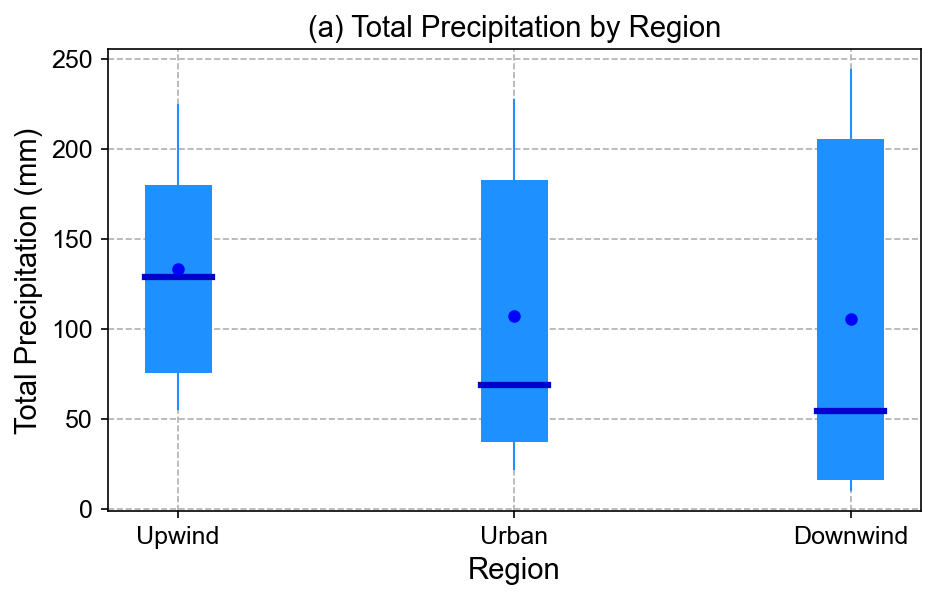

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Boxplot settings
barcolor = 'mediumorchid'
boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor='dodgerblue', alpha=1)
medianprops_ = dict(linestyle='-', linewidth=3, color='mediumblue')
meanpointprops_ = dict(marker='o', markeredgecolor='b', markerfacecolor='b', markersize=5)
whiskerprops_ = dict(linewidth=1, linestyle='-', color='dodgerblue')

# Extracting the 'Precipitation' column from each DataFrame
urban_precip = rain_in_urban_circle['Precipitation']
upwind_precip = rain_in_upwind_wedge['Precipitation']
downwind_precip = rain_in_downwind_wedge['Precipitation']

# Data to be plotted
data_to_plot = [upwind_precip, urban_precip, downwind_precip]

# Creating the boxplot
plt.figure(figsize=(7, 4), dpi=150)
bplot = plt.boxplot(data_to_plot, positions=[1, 2, 3], patch_artist=True, widths=0.2, notch=False, manage_ticks=False,
                    boxprops=boxprops_, medianprops=medianprops_, whis=[10, 90], whiskerprops=whiskerprops_, 
                    showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)

# Setting labels, title, and axis properties
plt.ylabel('Total Precipitation (mm)', fontsize=14)
plt.tick_params(axis='y')
plt.grid(ls='--')
plt.title('(a) Total Precipitation by Region', fontsize=14)
plt.xticks([1, 2, 3], ['Upwind', 'Urban', 'Downwind'])
plt.xlabel('Region', fontsize=14)
#plt.ylim([1, 2.0])  # Adjust the limits as needed

plt.show()


In [29]:
# First plot

total_precipitation_per_cell_downwind = np.sum(rain_in_downwind_wedge["Precipitation"])/4708
total_precipitation_per_cell_urban = np.sum(rain_in_urban_circle["Precipitation"])/17695
total_precipitation_per_cell_upwind = np.sum(rain_in_upwind_wedge["Precipitation"])/21733

# Compute storm density per 10km2 area 
cell_density_downwind = 4708/(area_downwind_km2/10)
cell_density_urban = 17695/(area_urban_km2/10)
cell_density_upwind = 21733/(area_upwind_km2/10)



In [30]:
max_eth20_upwind = np.mean(stats_upwind['maxETH_20dbz'].max(dim='times'))
max_eth20_urban = np.mean(stats_circle['maxETH_20dbz'].max(dim='times'))
max_eth20_downwind = np.mean(stats_downwind['maxETH_20dbz'].max(dim='times'))

max_dbz_upwind = np.mean(stats_upwind['max_dbz'].max(dim='times'))
max_dbz_urban = np.mean(stats_circle['max_dbz'].max(dim='times'))
max_dbz_downwind = np.mean(stats_downwind['max_dbz'].max(dim='times'))

In [31]:
merge_upwind = (4050/21733)*100
split_upwind = (3934/21733)*100

merge_urban = (3255/17695)*100
split_urban = (3240/17695)*100

merge_downwind = (887/4708)*100
split_downwind = (888/4708)*100

max_cellarea_upwind = np.mean(stats_upwind['cell_area'].max(dim='times'))
max_cellarea_urban = np.mean(stats_circle['cell_area'].max(dim='times'))
max_cellarea_downwind = np.mean(stats_downwind['cell_area'].max(dim='times'))


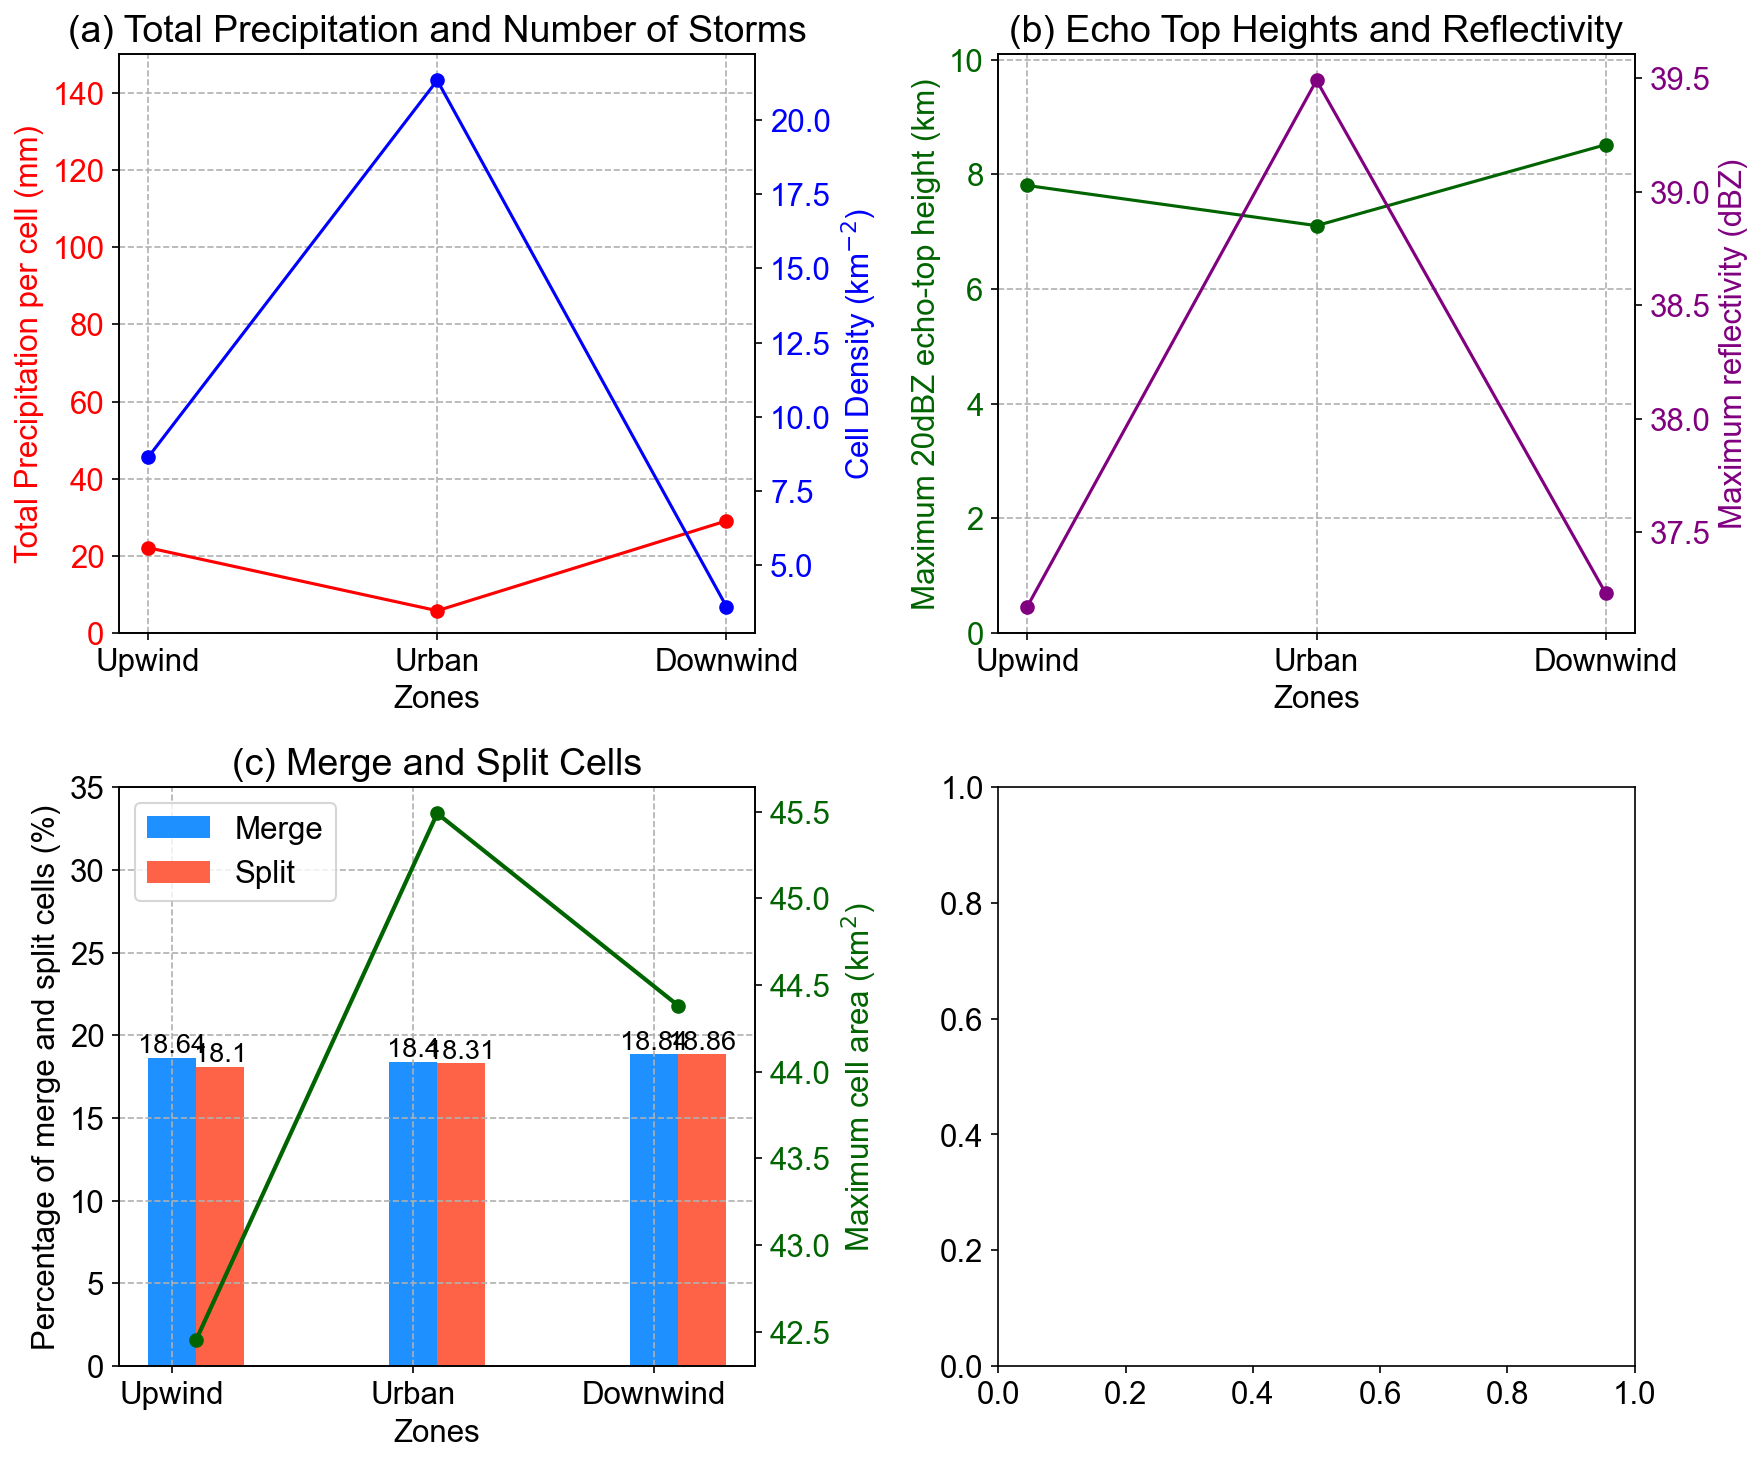

In [44]:
import matplotlib.pyplot as plt
import numpy as np
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Arial'

# Sample data for demonstration purposes
# Replace these with your actual data
categories = ['Upwind', 'Urban', 'Downwind']
values = [total_precipitation_per_cell_upwind, total_precipitation_per_cell_urban, total_precipitation_per_cell_downwind]  # 
fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=150)  # Adjust the figsize as needed

# First subplot
ax1 = axs[0,0]
ax1.set_ylim(0, 150.1)
ax1.plot(categories, values, marker='o', color='red')
ax1.set_title('(a) Total Precipitation and Number of Storms')
ax1.set_xlabel('Zones')
ax1.set_ylabel('Total Precipitation per cell (mm)', color="red")
ax1.grid(ls='--')
ax1.tick_params(axis='y', labelcolor='red')
ax1b = ax1.twinx()
ax1b.plot(categories, storms_values, marker='o', color='blue')
ax1b.set_ylabel('Cell Density (km$^{-2}$)', color='blue')
ax1b.tick_params(axis='y', labelcolor='blue')

# Second subplot
ax2 = axs[0,1]
ax2.set_ylim(0, 10.1)
ax2.plot(categories, eth20, marker='o', color='darkgreen')
ax2.set_title('(b) Echo Top Heights and Reflectivity')
ax2.set_xlabel('Zones')
ax2.set_ylabel('Maximum 20dBZ echo-top height (km)', color="darkgreen")
ax2.tick_params(axis='y', labelcolor='darkgreen')
ax2.grid(ls='--')
ax2b = ax2.twinx()
ax2b.plot(categories, dbz, marker='o', color='purple')
ax2b.set_ylabel('Maximum reflectivity (dBZ)', color='purple')
ax2b.tick_params(axis='y', labelcolor='purple')


# Third subplot
ax3 = axs[1,0]
bar_width = 0.2  # Adjust this value to make the bars thinner
ax3.set_ylim(0, 35)
ax3.bar(categories, merge, color='dodgerblue', width=bar_width, label='Merge')
for i, val in enumerate(merge):
    ax3.text(i, val, round(val, 2), va='bottom', ha='center', fontsize=13)
ax3.bar(np.arange(len(categories)) + bar_width, split, color='tomato', width=bar_width, label='Split')
ax3.set_title('(c) Merge and Split Cells')
ax3.set_xlabel('Zones')
ax3.set_ylabel('Percentage of merge and split cells (%)')
for i, val in enumerate(split):
    ax3.text(i + bar_width, val, round(val, 2), va='bottom', ha='center', fontsize=13)
ax3.legend(loc='upper left')
ax3.grid(ls='--')
ax3b = ax3.twinx()
marker_positions = np.arange(len(categories)) + bar_width / 2  # Adjust marker position to align with bar centers
ax3b.plot(marker_positions, maxarea, marker='o', color='darkgreen', linestyle='-', linewidth=2)
ax3b.set_ylabel('Maximum cell area (km$^2$)', color='darkgreen')
ax3b.tick_params(axis='y', labelcolor='darkgreen')


# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


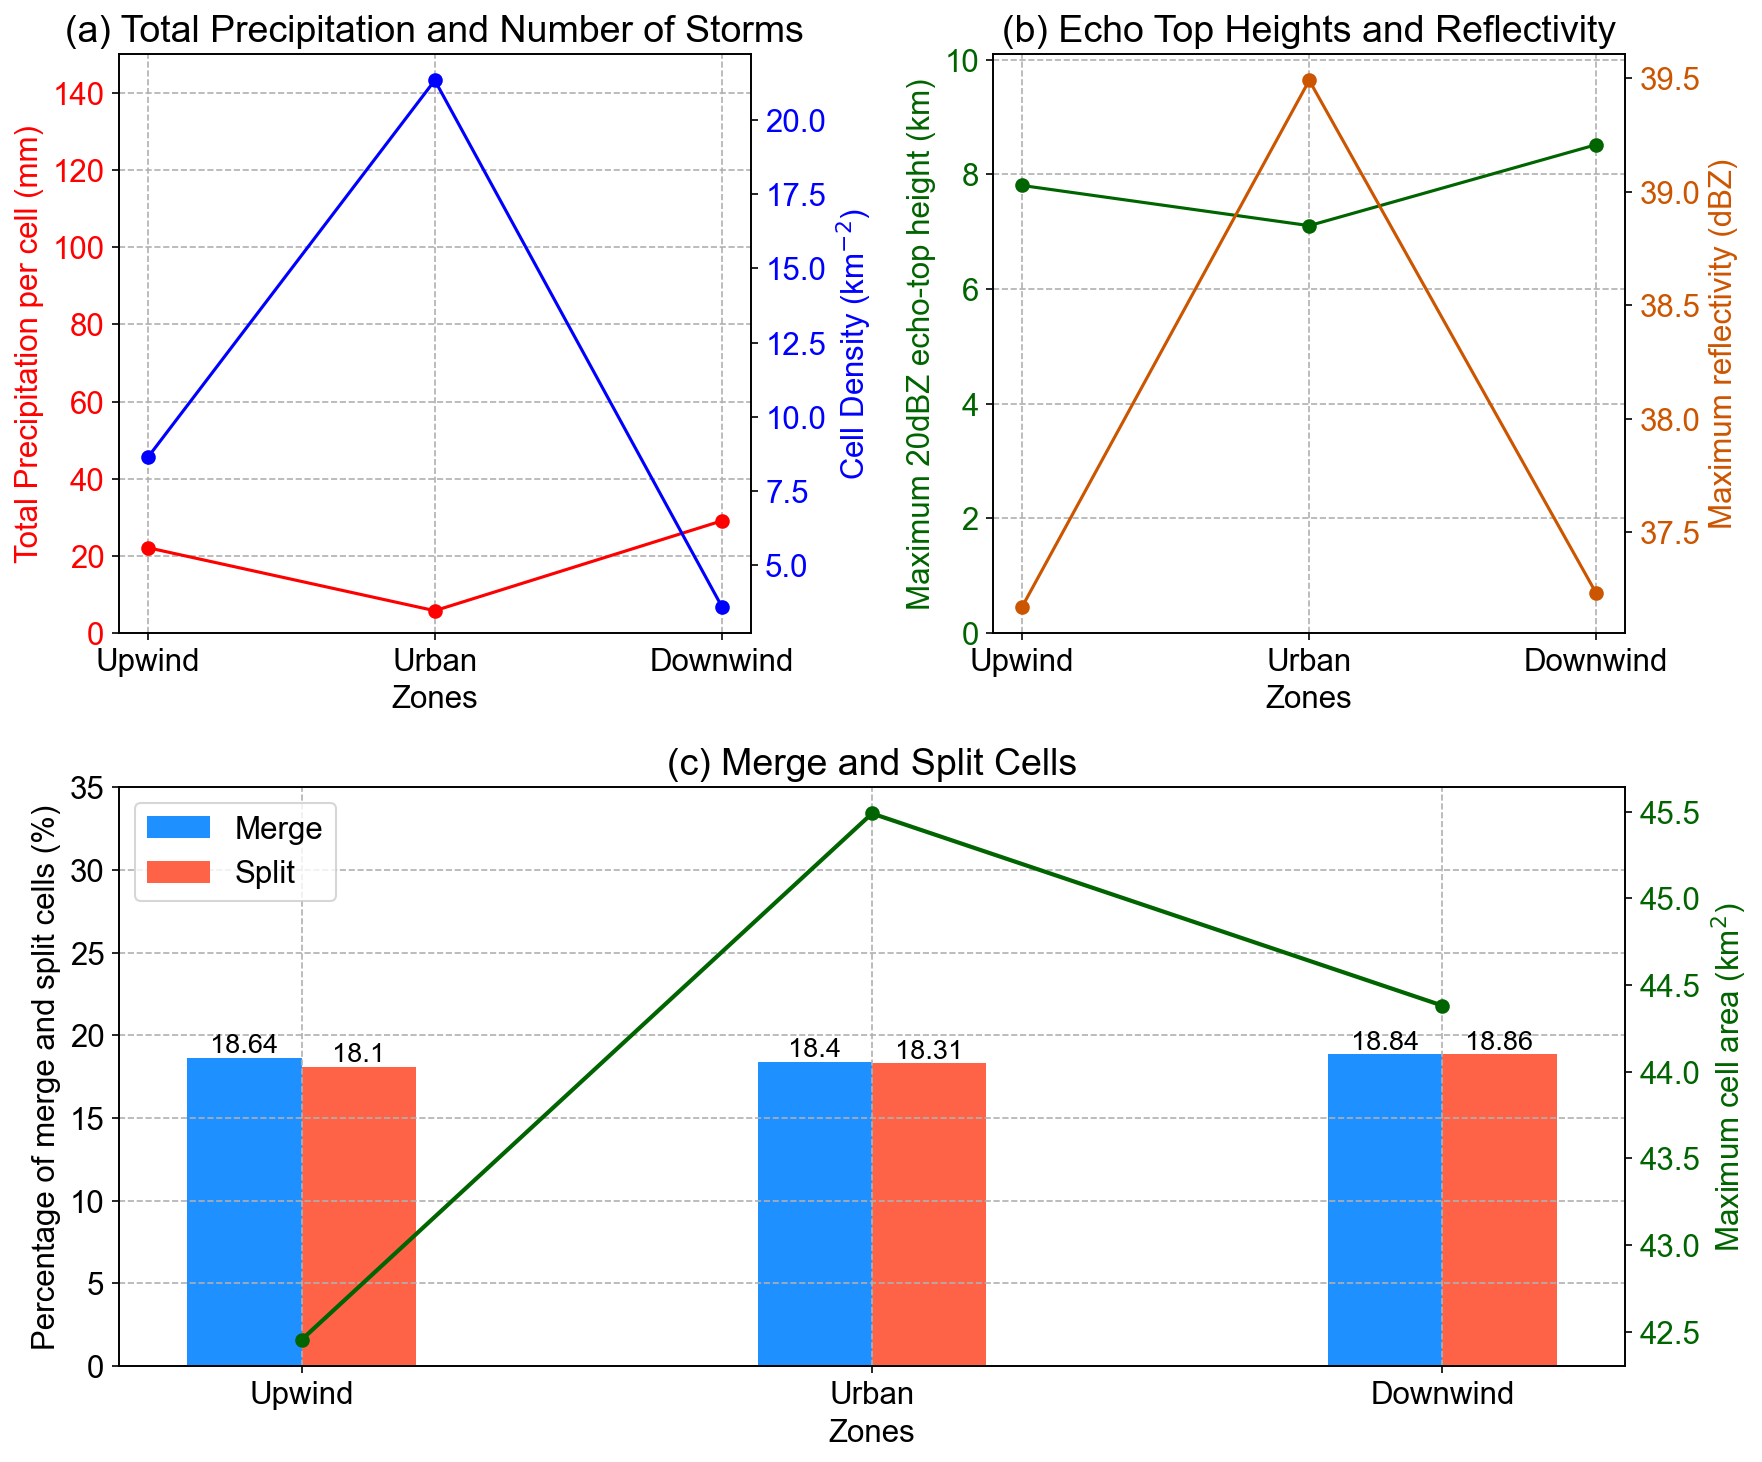

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Arial'

categories = ['Upwind', 'Urban', 'Downwind']
values = [total_precipitation_per_cell_upwind, total_precipitation_per_cell_urban, total_precipitation_per_cell_downwind]  # 
storms_values = [cell_density_upwind, cell_density_urban, cell_density_downwind]  # 
eth20 = [max_eth20_upwind, max_eth20_urban, max_eth20_downwind]  # 
dbz = [max_dbz_upwind, max_dbz_urban, max_dbz_downwind]  # 
merge = [merge_upwind, merge_urban, merge_downwind] 
split = [split_upwind, split_urban, split_downwind]  
maxarea = [max_cellarea_upwind, max_cellarea_urban, max_cellarea_downwind] 

fig = plt.figure(figsize=(12, 10), dpi=150)

# First subplot
ax1 = plt.subplot(2, 2, 1)
ax1.set_ylim(0, 150.1)
ax1.plot(categories, values, marker='o', color='red')
ax1.set_title('(a) Total Precipitation and Number of Storms')
ax1.set_xlabel('Zones')
ax1.set_ylabel('Total Precipitation per cell (mm)', color="red")
ax1.grid(ls='--')
ax1.tick_params(axis='y', labelcolor='red')
ax1b = ax1.twinx()
ax1b.plot(categories, storms_values, marker='o', color='blue')
ax1b.set_ylabel('Cell Density (km$^{-2}$)', color='blue')
ax1b.tick_params(axis='y', labelcolor='blue')

# Second subplot
ax2 = plt.subplot(2, 2, 2)
ax2.set_ylim(0, 10.1)
ax2.plot(categories, eth20, marker='o', color='darkgreen')
ax2.set_title('(b) Echo Top Heights and Reflectivity')
ax2.set_xlabel('Zones')
ax2.set_ylabel('Maximum 20dBZ echo-top height (km)', color="darkgreen")
ax2.tick_params(axis='y', labelcolor='darkgreen')
ax2.grid(ls='--')
ax2b = ax2.twinx()
ax2b.plot(categories, dbz, marker='o', color='#CC5500')
ax2b.set_ylabel('Maximum reflectivity (dBZ)', color='#CC5500')
ax2b.tick_params(axis='y', labelcolor='#CC5500')

# Remove the unused subplot (lower left)
fig.delaxes(plt.subplot(2, 2, 3))

# Third subplot, centered on the bottom row
ax3 = plt.subplot(2, 2, (3, 4))
bar_width = 0.2  # Adjust this value to make the bars thinner
ax3.set_ylim(0, 35)
ax3.bar(np.arange(len(categories)) - bar_width / 2, merge, color='dodgerblue', width=bar_width, label='Merge')
ax3.bar(np.arange(len(categories)) + bar_width / 2, split, color='tomato', width=bar_width, label='Split')
ax3.set_title('(c) Merge and Split Cells')
ax3.set_xlabel('Zones')
ax3.set_ylabel('Percentage of merge and split cells (%)')
ax3.set_xticks(np.arange(len(categories)))
ax3.set_xticklabels(categories)
ax3.legend(loc='upper left')
for i, val in enumerate(merge):
    ax3.text(i - 0.5*bar_width, val, round(val, 2), va='bottom', ha='center', fontsize=13)
for i, val in enumerate(split):
    ax3.text(i + 0.5*bar_width, val, round(val, 2), va='bottom', ha='center', fontsize=13)
ax3.grid(ls='--')
ax3b = ax3.twinx()
ax3b.plot(np.arange(len(categories)), maxarea, marker='o', color='darkgreen', linestyle='-', linewidth=2)
ax3b.set_ylabel('Maximum cell area (km$^2$)', color='darkgreen')
ax3b.tick_params(axis='y', labelcolor='darkgreen')

plt.tight_layout()
plt.show()


In [ ]:
cells_urban = []
indices_urban = []

for ihour in range(7):
    bin_start = ihour
    bin_end = ihour + 1
    if ihour == 0:
        condition = lifetime_circle < bin_end
    else:
        condition = (lifetime_circle >= bin_start) & (lifetime_circle < bin_end)
    bin_data = cell_area_circle.where(condition, drop=True)
    cells_urban.append(bin_data.values)
    bin_indices = np.where(condition)[0]  
    indices_urban.append(bin_indices)
cell_density_urban = [np.count_nonzero(~np.isnan(arr)) / (area_urban_km2 / 10) for arr in cells_urban]


In [ ]:
cells_upwind = []
indices_upwind = []

for ihour in range(7):
    bin_start = ihour
    bin_end = ihour + 1
    if ihour == 0:
        condition = lifetime_upwind < bin_end
    else:
        condition = (lifetime_upwind >= bin_start) & (lifetime_upwind < bin_end)
    bin_data = cell_area_upwind.where(condition, drop=True)
    cells_upwind.append(bin_data.values)
    bin_indices = np.where(condition)[0]  
    indices_upwind.append(bin_indices)
cell_density_upwind = [np.count_nonzero(~np.isnan(arr)) / (area_upwind_km2 / 10) for arr in cells_upwind]


In [ ]:
cells_downwind = []
indices_downwind = []

for ihour in range(7):
    bin_start = ihour
    bin_end = ihour + 1
    if ihour == 0:
        condition = lifetime_downwind < bin_end
    else:
        condition = (lifetime_downwind >= bin_start) & (lifetime_downwind < bin_end)
    bin_data = cell_area_downwind.where(condition, drop=True)
    cells_downwind.append(bin_data.values)
    bin_indices = np.where(condition)[0]  
    indices_downwind.append(bin_indices)
cell_density_downwind = [np.count_nonzero(~np.isnan(arr)) / (area_downwind_km2 / 10) for arr in cells_downwind]


In [ ]:
cell_density_downwind

[11.300413253189319,
 4.8528958564398845,
 1.135947331023782,
 0.27228987340543054,
 0.17257808877808978,
 0.0,
 0.0]

## Obtain the unique base times of the cells in each of the regions

In [ ]:
import xarray as xr
import numpy as np


nc_data_urban = stats_circle
nc_data_downwind = stats_downwind
nc_data_upwind = stats_upwind

# Extract and find unique base_time values for each dataset
base_time_urban = np.unique(nc_data_urban['base_time'].values)
base_time_downwind = np.unique(nc_data_downwind['base_time'].values)
base_time_upwind = np.unique(nc_data_upwind['base_time'].values)

# Find exclusive base_time values for each dataset
exclusive_to_urban = np.setdiff1d(base_time_urban, np.union1d(base_time_downwind, base_time_upwind))
exclusive_to_downwind = np.setdiff1d(base_time_downwind, np.union1d(base_time_urban, base_time_upwind))
exclusive_to_upwind = np.setdiff1d(base_time_upwind, np.union1d(base_time_downwind, base_time_urban))

# View the base times of the urban region
exclusive_to_urban

array(['2022-06-01T01:08:19.436000000', '2022-06-01T01:12:01.468000000',
       '2022-06-01T01:52:49.100999936', '2022-06-01T02:15:00.281999872',
       '2022-06-03T04:31:35.201999872', '2022-06-03T04:35:17.980000000',
       '2022-06-03T04:38:59.779000064', '2022-06-03T04:42:42.598000128',
       '2022-06-03T04:53:50.344000000', '2022-06-03T04:57:33.060999936',
       '2022-06-03T05:32:09.966000128', '2022-06-04T04:07:05.108999936',
       '2022-06-04T04:10:47.032000000', '2022-06-04T04:14:28.791000064',
       '2022-06-04T15:52:06.696999936', '2022-06-04T16:01:59.345999872',
       '2022-06-05T20:33:59.996999936', '2022-06-05T20:43:52.888999936',
       '2022-06-06T10:55:38.883000064', '2022-06-06T11:05:31.708999936',
       '2022-06-06T15:13:35.461999872', '2022-06-06T15:23:27.900999936',
       '2022-06-06T16:12:51.446000128', '2022-06-06T16:22:43.980000000',
       '2022-06-06T17:22:00.099000064', '2022-06-06T17:31:52.508999936',
       '2022-06-06T23:48:20.783000064', '2022-06-06

In [ ]:
exclusive_to_upwind

array(['2022-06-03T05:47:00.312999936', '2022-06-03T05:50:42.349999872',
       '2022-06-03T05:54:24.092000000', ...,
       '2022-08-31T16:18:44.467000064', '2022-08-31T16:23:29.353999872',
                                 'NaT'], dtype='datetime64[ns]')

In [ ]:
exclusive_to_downwind

array(['2022-06-01T02:07:36.484999936', '2022-06-04T07:21:03.271000064',
       '2022-06-04T07:24:45.248000000', '2022-06-04T07:28:27.049999872',
       '2022-06-04T07:39:33.783000064', '2022-06-04T07:43:15.598000128',
       '2022-06-04T07:46:58.572000000', '2022-06-04T08:27:47.052000000',
       '2022-06-04T08:31:28.918000128', '2022-06-04T08:35:12.272000000',
       '2022-06-04T08:45:04.667000064', '2022-06-04T08:54:57.144999936',
       '2022-06-04T09:54:13.376000000', '2022-06-04T20:14:35.688999936',
       '2022-06-04T20:18:31.652999936', '2022-06-05T15:17:56.615000064',
       '2022-06-05T15:27:49.440999936', '2022-06-05T19:05:06.092000000',
       '2022-06-05T19:14:58.916999936', '2022-06-08T03:30:46.945999872',
       '2022-06-08T03:40:39.620999936', '2022-06-08T21:38:34.911000064',
       '2022-06-08T21:48:27.521999872', '2022-06-09T22:04:05.368000000',
       '2022-06-09T22:07:48.996000000', '2022-06-10T09:59:08.830000128',
       '2022-06-10T10:09:01.168000000', '2022-06-11